# Fine-tuning con LoRA de Ministral3-8B

## Importar librerías

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from dotenv import load_dotenv

from transformers import (
    Mistral3ForConditionalGeneration,
    FineGrainedFP8Config,
    get_cosine_schedule_with_warmup,
)
from mistral_common.tokens.tokenizers.mistral import MistralTokenizer
from mistral_common.protocol.instruct.messages import UserMessage, SystemMessage
from mistral_common.protocol.instruct.request import ChatCompletionRequest

from peft import LoraConfig, get_peft_model, TaskType

# Cargar variables de entorno desde .env
load_dotenv('.env')
# Si no funciona, intentar con ruta relativa al notebook
if not os.getenv("HF_TOKEN"):
    load_dotenv()


In [2]:
# Cargar el token de HuggingFace desde .env
HF_TOKEN = os.getenv("HF_TOKEN", "")
if HF_TOKEN:
    print("✓ HF_TOKEN cargado desde .env")
else:
    print("⚠ HF_TOKEN no encontrado en .env - Continuando sin token")


✓ HF_TOKEN cargado desde .env


## Configuración y parámetros

In [3]:
MODEL_NAME  = "mistralai/Ministral-3-8B-Instruct-2512"
MAIN_PATH   = ".."
GROUP_ID    = "BeingChillingWeWillWin"

TEXT_COLUMN  = "tweet"
LABEL_COLUMN = "task1"

DATA_TRAIN_PATH = os.path.join(MAIN_PATH, "preprocessed_data", "train_preprocessed_v2.json")
DATA_VAL_PATH   = os.path.join(MAIN_PATH, "preprocessed_data", "val_preprocessed_v2.json")
DATA_TEST_PATH  = os.path.join(MAIN_PATH, "preprocessed_data", "test_preprocessed_v2.json")

OUTPUT_DIR      = os.path.join(MAIN_PATH, "results_v2", "3Ministral8B_LoRA")
SAVE_PATH       = os.path.join(MAIN_PATH, "results_v2", "3Ministral8B_LoRA", "lora_weights")
PREDICTIONS_DIR = os.path.join(MAIN_PATH, "results_v2", "3Ministral8B_LoRA", "predictions")

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(SAVE_PATH, exist_ok=True)
os.makedirs(PREDICTIONS_DIR, exist_ok=True)

# ── Hiperparámetros ──
TRAIN_BATCH_SIZE = 4      # batch para entrenamiento (gradient accumulation compensa el tamaño pequeño)
GRAD_ACCUM_STEPS = 8      # pasos de acumulación → batch efectivo = 4 * 8 = 32
INFER_BATCH_SIZE = 16     # batch para inferencia
MAX_INPUT_LEN    = 256    # tokens máximos del prompt
MAX_NEW_TOKENS   = 5      # tokens máximos a generar (YES / NO)
NUM_EPOCHS       = 3
LEARNING_RATE    = 2e-4

## Carga y preprocesamiento de datos

In [4]:
train_df = pd.read_json(DATA_TRAIN_PATH)
val_df   = pd.read_json(DATA_VAL_PATH)
test_df  = pd.read_json(DATA_TEST_PATH)

label_map         = {"NO": 0, "YES": 1}
label_map_inverse = {0: "NO", 1: "YES"}

train_df["label"] = train_df[LABEL_COLUMN].map(label_map)
val_df["label"]   = val_df[LABEL_COLUMN].map(label_map)

print(f"Text column used : {TEXT_COLUMN}")
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print("\nDistribución TRAIN:")
print(train_df[LABEL_COLUMN].value_counts())
print("\nDistribución VAL:")
print(val_df[LABEL_COLUMN].value_counts())

Text column used : tweet
Train: 5154 | Val: 910 | Test: 934

Distribución TRAIN:
task1
NO     2862
YES    2292
Name: count, dtype: int64

Distribución VAL:
task1
NO     505
YES    405
Name: count, dtype: int64


## Carga del modelo y tokenizer

In [5]:
# Cargar el tokenizer de Mistral
# Mistral-3 usa el tokenizer v3 de Mistral
tokenizer = MistralTokenizer.v3(is_tekken=True)

# El modelo viene pre-cuantizado en FP8, usamos su configuración nativa
model = Mistral3ForConditionalGeneration.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    quantization_config=FineGrainedFP8Config(dequantize=True),
    token=HF_TOKEN
)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,   # LLM generativo, no SEQ_CLS
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/531 [00:00<?, ?it/s]

trainable params: 8,814,592 || all params: 8,926,840,832 || trainable%: 0.0987


## Definición del prompt

Usamos un prompt de instrucción con formato chat. Para el fine-tuning, añadimos la respuesta esperada al final para que el modelo aprenda a generarla.

In [6]:
SYSTEM_PROMPT = (
    "You are a text classification assistant. "
    "Your task is to determine whether the following text contains sexism. "
    "Answer with exactly one word: YES or NO."
)

def build_messages(text: str):
    """Mensajes de chat para inferencia (sin respuesta)."""
    return [
        SystemMessage(content=SYSTEM_PROMPT),
        UserMessage(content=f"Text: {text}\n\nDoes this text contain sexism?"),
    ]

def build_training_prompt(text: str, label_str: str) -> list:
    """Tokens para entrenamiento: incluye la respuesta esperada al final."""
    messages = build_messages(text)
    tokenized = tokenizer.encode_chat_completion(
        ChatCompletionRequest(messages=messages)
    ).tokens
    
    # Add the label tokens using the internal tokenizer
    # MistralTokenizer v3 uses Tekken tokenizer internally
    label_text = f"{label_str}</s>"  # Add EOS token manually
    label_tokens = tokenizer.instruct_tokenizer.tokenizer.encode(label_text, bos=False, eos=False)
    return tokenized + label_tokens


## Dataset de PyTorch para fine-tuning

In [7]:
class SexismDataset(Dataset):
    def __init__(self, df, text_col, label_col_str, max_length):
        self.samples = []
        for _, row in df.iterrows():
            label_str = row[label_col_str]   # "YES" o "NO"
            tokens = build_training_prompt(row[text_col], label_str)
            # Truncate if needed
            if len(tokens) > max_length:
                tokens = tokens[:max_length]
            self.samples.append(tokens)
        self.max_length = max_length

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


def collate_fn(batch_tokens):
    """Pad the batch and create attention masks."""
    max_len = max(len(tokens) for tokens in batch_tokens)
    
    input_ids_list = []
    attention_mask_list = []
    
    for tokens in batch_tokens:
        # Pad with 0 (or a specific pad token if needed)
        padding_length = max_len - len(tokens)
        padded_tokens = tokens + [0] * padding_length
        attention_mask = [1] * len(tokens) + [0] * padding_length
        
        input_ids_list.append(padded_tokens)
        attention_mask_list.append(attention_mask)
    
    input_ids = torch.tensor(input_ids_list, dtype=torch.long)
    attention_mask = torch.tensor(attention_mask_list, dtype=torch.long)
    
    # Labels: copy input_ids and mask padding with -100
    labels = input_ids.clone()
    labels[labels == 0] = -100

    return {
        "input_ids":      input_ids,
        "attention_mask": attention_mask,
        "labels":         labels,
    }


train_dataset = SexismDataset(train_df, TEXT_COLUMN, LABEL_COLUMN, MAX_INPUT_LEN)
val_dataset   = SexismDataset(val_df,   TEXT_COLUMN, LABEL_COLUMN, MAX_INPUT_LEN)

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=TRAIN_BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"Batches de entrenamiento : {len(train_loader)}")
print(f"Batches de validación    : {len(val_loader)}")

Batches de entrenamiento : 1289
Batches de validación    : 228


## Entrenamiento con LoRA

Epoch 1/3 | Train Loss: 2.3163 | Val Loss: 2.0990


  ✓ Mejor modelo guardado (val_loss=2.0990)


Epoch 2/3 | Train Loss: 2.0304 | Val Loss: 2.0346


  ✓ Mejor modelo guardado (val_loss=2.0346)


Epoch 3/3 | Train Loss: 1.9499 | Val Loss: 2.0379


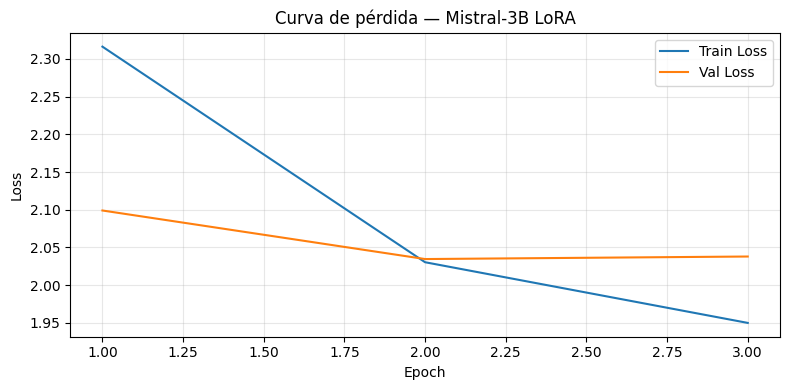

In [8]:
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=0.01,
)

total_steps   = (len(train_loader) // GRAD_ACCUM_STEPS) * NUM_EPOCHS
warmup_steps  = total_steps // 10

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
)

train_losses = []
val_losses   = []
best_val_loss = float("inf")

for epoch in range(1, NUM_EPOCHS + 1):
    # ── TRAIN ──
    model.train()
    epoch_loss    = 0.0
    optimizer.zero_grad()

    for step, batch in enumerate(train_loader, start=1):
        batch = {k: v.to("cuda") for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss / GRAD_ACCUM_STEPS
        loss.backward()
        epoch_loss += outputs.loss.item()

        if step % GRAD_ACCUM_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ── VALIDATION ──
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to("cuda") for k, v in batch.items()}
            val_loss += model(**batch).loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch}/{NUM_EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Guardar el mejor modelo (solo los pesos LoRA)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model.save_pretrained(SAVE_PATH)
        # Note: MistralTokenizer v3 no necesita guardarse, se puede recrear con MistralTokenizer.v3(is_tekken=True)
        print(f"  ✓ Mejor modelo guardado (val_loss={best_val_loss:.4f})")

# Curva de pérdida
plt.figure(figsize=(8, 4))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, NUM_EPOCHS + 1), val_losses,   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Curva de pérdida — Mistral-3B LoRA")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()
